### Spark DataFrame API with Python
- **Goal** : Illustrate some methods associated with ***Spark DataFrame API***
- **Data manipulated** : MovieLens 1M Dataset https://grouplens.org/datasets/movielens/

In [2]:
spark.version

Out[75]: '3.0.0'

##### Import needed libraries

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

##### Load ***"movies.csv"*** file as moviesDF

In [6]:
moviesDF = spark.read.format("csv").option("inferSchema","true").option("header","true").load("/FileStore/tables/movies.csv").cache()

##### Explore moviesDF

In [8]:
moviesDF.printSchema()

root
-- movieId: integer (nullable = true)
-- title: string (nullable = true)
-- genres: string (nullable = true)

In [9]:
moviesDF.dtypes

Out[79]: [('movieId', 'int'), ('title', 'string'), ('genres', 'string')]

In [10]:
moviesDF.show(10)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
 6| Heat (1995)|Action|Crime|Thri...|
 7| Sabrina (1995)| Comedy|Romance|
 8| Tom and Huck (1995)| Adventure|Children|
 9| Sudden Death (1995)| Action|
 10| GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows

In [11]:
moviesDF.count()

Out[81]: 9742

##### Load ***"ratings.csv"*** file as ratingsDF

In [13]:
ratingsDF = spark.read.format("csv").option("inferSchema","true").option("header","true").load("/FileStore/tables/ratings.csv").cache()

##### Explore ratingsDF

In [15]:
ratingsDF.printSchema()

root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- rating: double (nullable = true)
-- timestamp: integer (nullable = true)

In [16]:
ratingsDF.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [17]:
ratingsDF.count()

Out[85]: 100836

##### Validate that ***userId*** and ***movieId*** combination is unique in ratingsDF

In [19]:
ratingsDF.groupBy("movieId","userId").count().filter("count != 1").show()

+-------+------+-----+
movieId|userId|count|
+-------+------+-----+
+-------+------+-----+

##### Find top 10 movies based on the highest average ratings. Consider only movies wiht at least 100 ratings. Show movieId, title, average rating and rating count columns. Order the result by average rating in decreasing order.

In [21]:
a = ratingsDF.groupBy("movieId").agg(
  count("movieId").alias("count"), 
  avg("rating").alias("avg_rating"))

a.show(5)
a.count()

+-------+-----+-----------------+
movieId|count| avg_rating|
+-------+-----+-----------------+
 1580| 165|3.487878787878788|
 2366| 25| 3.64|
 3175| 75| 3.58|
 1088| 42|3.369047619047619|
 32460| 4| 4.25|
+-------+-----+-----------------+
only showing top 5 rows

Out[87]: 9724

In [22]:
a.alias("t1").join(moviesDF.alias("t2"), col("t1.movieId")==col("t2.movieId")).filter("count > 100").orderBy(desc("avg_rating")).select("t1.movieId", "title","avg_rating", "count").limit(10).show()

+-------+--------------------+-----------------+-----+
movieId| title| avg_rating|count|
+-------+--------------------+-----------------+-----+
 318|Shawshank Redempt...|4.429022082018927| 317|
 858|Godfather, The (1...| 4.2890625| 192|
 2959| Fight Club (1999)|4.272935779816514| 218|
 1221|Godfather: Part I...| 4.25968992248062| 129|
 48516|Departed, The (2006)|4.252336448598131| 107|
 1213| Goodfellas (1990)| 4.25| 126|
 58559|Dark Knight, The ...|4.238255033557047| 149|
 50|Usual Suspects, T...|4.237745098039215| 204|
 1197|Princess Bride, T...|4.232394366197183| 142|
 260|Star Wars: Episod...|4.231075697211155| 251|
+-------+--------------------+-----------------+-----+

##### Same question to answer by using SQL

Show temporary views for current Spark session

In [25]:
sql("show tables").show()

+--------+---------+-----------+
database|tableName|isTemporary|
+--------+---------+-----------+
 default| diamonds| false|
 default| survey| false|
 | movies| true|
 | ratings| true|
+--------+---------+-----------+

In [26]:
moviesDF.createOrReplaceTempView("movies")
ratingsDF.createOrReplaceTempView("ratings")
sql("show tables").show()

+--------+---------+-----------+
database|tableName|isTemporary|
+--------+---------+-----------+
 default| diamonds| false|
 default| survey| false|
 | movies| true|
 | ratings| true|
+--------+---------+-----------+

In [27]:
sql("""
SELECT t1.movieId, t1.title, avg(t2.rating) avg_rating, count(1) rating_count
FROM movies t1 join ratings t2 on t1.movieId = t2.movieId
GROUP BY t1.movieId, t1.title
HAVING rating_count >= 100
ORDER BY avg_rating desc
LIMIT 10
""").show()

+-------+--------------------+-----------------+------------+
movieId| title| avg_rating|rating_count|
+-------+--------------------+-----------------+------------+
 318|Shawshank Redempt...|4.429022082018927| 317|
 858|Godfather, The (1...| 4.2890625| 192|
 2959| Fight Club (1999)|4.272935779816514| 218|
 1221|Godfather: Part I...| 4.25968992248062| 129|
 48516|Departed, The (2006)|4.252336448598131| 107|
 1213| Goodfellas (1990)| 4.25| 126|
 912| Casablanca (1942)| 4.24| 100|
 58559|Dark Knight, The ...|4.238255033557047| 149|
 50|Usual Suspects, T...|4.237745098039215| 204|
 1197|Princess Bride, T...|4.232394366197183| 142|
+-------+--------------------+-----------------+------------+

##### Find average rating of each genre

In [29]:
genre_avg_rating = ratingsDF.alias("t1").join(moviesDF.alias("t2"), col("t1.movieId")==col("t2.movieId")).select("rating", explode(split("genres",r"\|")).alias("genre")).groupBy("genre").agg(count("genre").alias("count"),avg("rating").alias("avg_rating")).sort(desc("avg_rating"))

genre_avg_rating.show(5)

+-----------+-----+------------------+
 genre|count| avg_rating|
+-----------+-----+------------------+
 Film-Noir| 870| 3.920114942528736|
 War| 4859| 3.8082938876312|
Documentary| 1219| 3.797785069729286|
 Crime|16681| 3.658293867274144|
 Drama|41928|3.6561844113718758|
+-----------+-----+------------------+
only showing top 5 rows

##### Plot average rating of each genre

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Convert Spark DataFram to Pandas DataFrame

In [33]:
df = genre_avg_rating.toPandas()
df.head()

,genre,count,avg_rating
0,Film-Noir,870,3.920115
1,War,4859,3.808294
2,Documentary,1219,3.797785
3,Crime,16681,3.658294
4,Drama,41928,3.656184


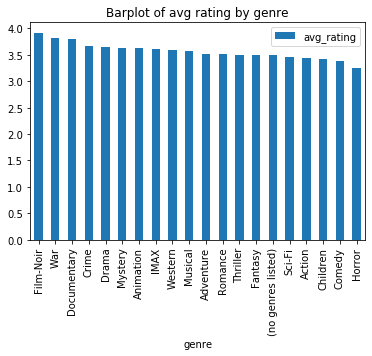

In [34]:
df.plot("genre", "avg_rating", "bar", title = "Barplot of avg rating by genre")